# Exploration of hippynn graph system

## Let's revisit the simple training script "barebones.py"

The script begins by defining a model and "assembling" it for training. What does that really mean?

In [1]:
import torch

# Setup pytorch things
torch.set_default_dtype(torch.float32)

import hippynn
hippynn.settings.WARN_LOW_DISTANCES=False

# Hyperparameters for the network
# These are set deliberately small so that you can easily run the example on a laptop or similar.
network_params = {
    "possible_species": [0, 1, 6, 7, 8, 16],  # Z values of the elements in QM7
    "n_features": 20,  # Number of neurons at each layer
    "n_sensitivities": 20,  # Number of sensitivity functions in an interaction layer
    "dist_soft_min": 1.6,  # qm7 is in Bohr!
    "dist_soft_max": 10.0,
    "dist_hard_max": 12.5,
    "n_interaction_layers": 2,  # Number of interaction blocks
    "n_atom_layers": 3,  # Number of atom layers in an interaction block
}

# Define a model
from hippynn.graphs import inputs, networks, targets, physics

species = inputs.SpeciesNode(db_name="Z")
positions = inputs.PositionsNode(db_name="R")

network = networks.Hipnn("hipnn_model", (species, positions), module_kwargs=network_params)
henergy = targets.HEnergyNode("HEnergy", network, db_name="T")
# hierarchicality = henergy.hierarchicality

# define loss quantities
from hippynn.graphs import loss

mse_energy = loss.MSELoss.of_node(henergy)
mae_energy = loss.MAELoss.of_node(henergy)
rmse_energy = mse_energy ** (1 / 2)

# Validation losses are what we check on the data between epochs -- we can only train to
# a single loss, but we can check other metrics too to better understand how the model is training.
# There will also be plots of these things over time when training completes.
validation_losses = {
    "RMSE": rmse_energy,
    "MAE": mae_energy,
    "MSE": mse_energy,
}

# This piece of code glues the stuff together as a pytorch model,
# dropping things that are irrelevant for the losses defined.
training_modules, db_info = hippynn.experiment.assemble_for_training(mse_energy, validation_losses)

...

Determined Inputs: ["Positions(db_name='R')", "Species(db_name='Z')"]
Determined Outputs: ['HEnergy.mol_energy']
Determined Targets: ['HEnergy.mol_energy']
Device was not specified. Attempting to default to device: cpu


Ellipsis

## Assembling a graph for training

Perhaps one of the more mysterious lines is:

`training_modules, db_info = hippynn.experiment.assemble_for_training(mse_energy, validation_losses)`

In [2]:
db_info

{'inputs': ['R', 'Z'], 'targets': ['T']}

In [3]:
type(training_modules)

hippynn.experiment.assembly.TrainingModules

`training_modules` contain 3 objects: A `model`, a (training) `loss`, and an `evaluator` (which computes the validation losses)

In [4]:
for x in [training_modules.model,training_modules.loss,training_modules.evaluator]:
    print(type(x))

<class 'hippynn.graphs.graph.GraphModule'>
<class 'hippynn.graphs.graph.GraphModule'>
<class 'hippynn.experiment.evaluator.Evaluator'>


With the python graphviz interface installed, it is easy to visualize what a GraphModule does:

In [5]:
from hippynn.graphs.viz import visualize_connected_nodes, visualize_graph_module, visualize_node_set

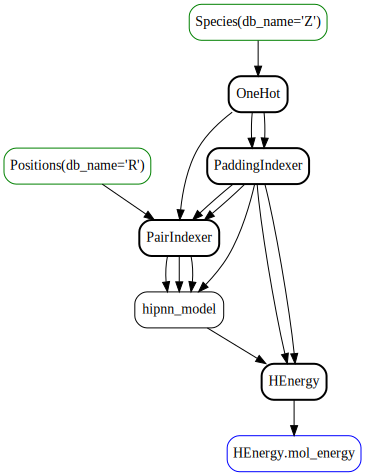

In [6]:
visualize_graph_module(training_modules.model)

Hidden in the multiple arrows are child nodes. Each node with multiple arrows was a MultiNode, that actually outputs multiple tensors.

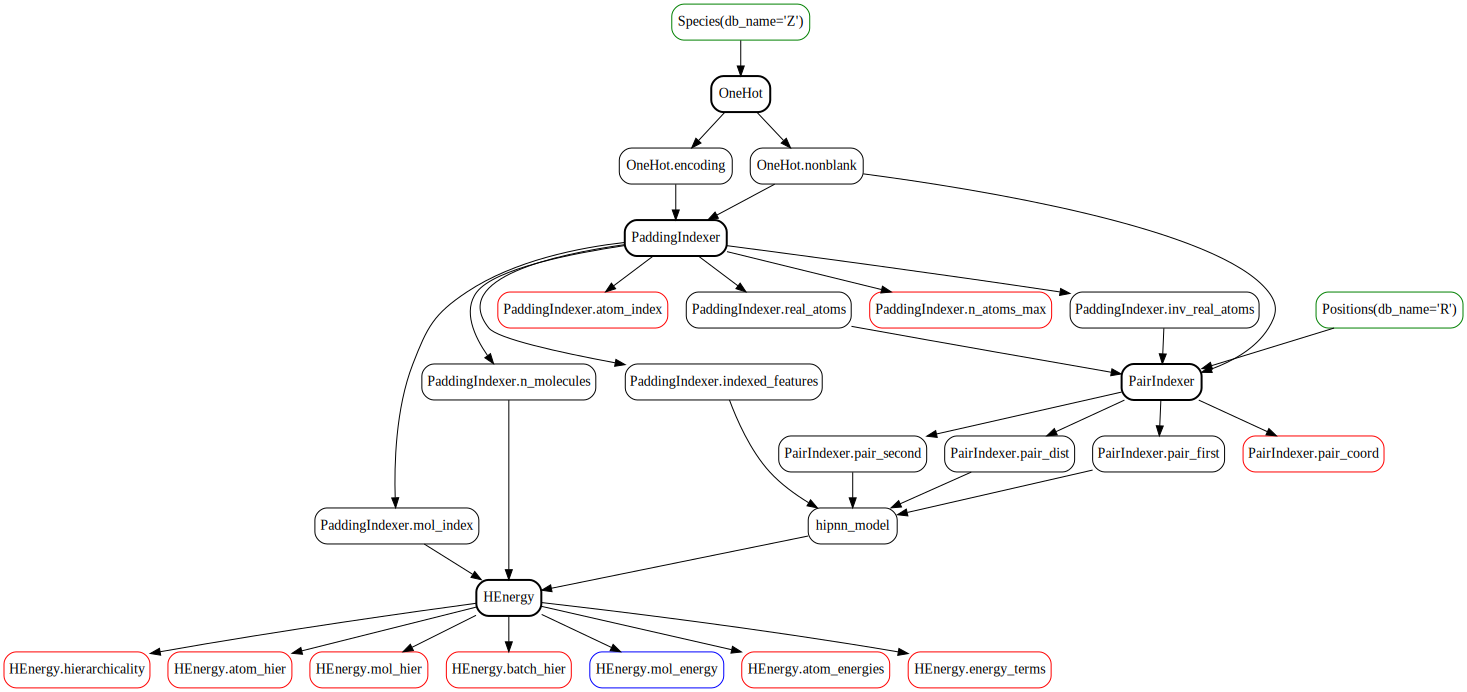

In [7]:
visualize_graph_module(training_modules.model,compactify=False)

Let's take a look at just the one-hot encoder. The `node_from_name` method will make it easy to get a reference to a particular node from the printed or visualized information.

In [8]:
onehot = training_modules.model.node_from_name("OneHot")

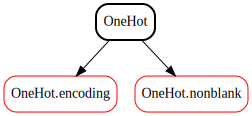

In [9]:
visualize_node_set([onehot,*onehot.children],compactify=False)

A Predictor interface can make it simpler to compute the value of some nodes over a database.

In [10]:
from hippynn.graphs import Predictor
onehot_predictor = Predictor([species],[*onehot.children,network.input_features])

If we load a database, we can use the predictor to make predictions over the database:

In [11]:
# If you don't hvae this database, follow instructions at /examples/process_QM7_data.py !
database = hippynn.databases.DirectoryDatabase(
    name="data-qm7",  # Prefix for arrays in the directory
    directory="../../datasets/qm7_processed",
    test_size=0.1,  # Fraction or number of samples to test on
    valid_size=0.1,  # Fraction or number of samples to validate on
    seed=2001,  # Random seed for splitting data
    **db_info,  # Adds the inputs and targets db_names from the model as things to load
)

Arrays found:  {'Z': 'data-qm7Z.npy', 'X': 'data-qm7X.npy', 'T_shaped': 'data-qm7T_shaped.npy', 'R': 'data-qm7R.npy', 'F': 'data-qm7F.npy', 'P': 'data-qm7P.npy', 'T': 'data-qm7T.npy', 'Z_float': 'data-qm7Z_float.npy'}
Data types:
{'Z': dtype('int64'), 'R': dtype('float32'), 'T': dtype('float32')}
All arrays:
--------------------------------------------------------------------------------------
| Name               | dtype              | shape                                    |
--------------------------------------------------------------------------------------
| Z                  | dtype('int64')     | (7165, 23)                               |
| R                  | dtype('float32')   | (7165, 23, 3)                            |
| T                  | dtype('float32')   | (7165, 1)                                |
--------------------------------------------------------------------------------------
Finished checking input and target arrays; all necessary arrays were found.
Datab

In [12]:
outputs = onehot_predictor.apply_to_database(database,batch_size=512)
outputs.keys()

Predictor:   0%|          | 0/2 [00:00<?, ?batch/s]

Predictor:   0%|          | 0/2 [00:00<?, ?batch/s]

Predictor:   0%|          | 0/12 [00:00<?, ?batch/s]

dict_keys(['test', 'valid', 'train'])

In [13]:
train_outs = outputs['train']

The outputs can be indexed by the node name to get the output value:

In [14]:
train_outs["OneHot.encoding"]

tensor([[[False,  True, False, False, False],
         [ True, False, False, False, False],
         [ True, False, False, False, False],
         ...,
         [False, False, False, False, False],
         [False, False, False, False, False],
         [False, False, False, False, False]],

        [[False,  True, False, False, False],
         [False,  True, False, False, False],
         [ True, False, False, False, False],
         ...,
         [False, False, False, False, False],
         [False, False, False, False, False],
         [False, False, False, False, False]],

        [[False,  True, False, False, False],
         [False,  True, False, False, False],
         [False, False, False,  True, False],
         ...,
         [False, False, False, False, False],
         [False, False, False, False, False],
         [False, False, False, False, False]],

        ...,

        [[False,  True, False, False, False],
         [False,  True, False, False, False],
         [False,  

You can also get the value for a node using the node directly:

In [15]:
onehot_train = train_outs[onehot.encoding]

In [16]:
input_features = train_outs["PaddingIndexer.indexed_features"]

In this context, the input features look to be the same.

In [17]:
print(input_features.shape,input_features.dtype)
print(onehot_train.shape,onehot_train.dtype)
print(torch.equal(onehot_train,input_features))

torch.Size([5733, 23, 5]) torch.bool
torch.Size([5733, 23, 5]) torch.bool
True


But actually, the predictor is hiding some complexity. Let's take a look at a more rudimentary GraphModule constructed directly - we will manually specify the set of inputs and outputs.

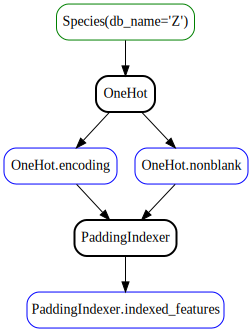

In [18]:
from hippynn.graphs import GraphModule
onehot_graphmodule = GraphModule([species],[onehot.encoding,onehot.nonblank,network.input_features])
visualize_graph_module(onehot_graphmodule)

We will also manually graph the input array:

In [19]:
arrays = database.splits['train']

outputs_graph = onehot_graphmodule(arrays['Z'])

In [20]:
type(outputs_graph)

tuple

In [21]:
len(outputs_graph)

3

Each one corresponds to one of the outputs directly: `[onehot.encoding,onehot.nonblank,network.input_features]`

In [22]:
features_graph = outputs_graph[-1]

What share the the features now?

In [23]:
features_graph.shape

torch.Size([88557, 5])

Hmm, that's not familiar.

Let's compare this to the output of the Predictor interface:

In [24]:
input_features.shape,features_graph.shape

(torch.Size([5733, 23, 5]), torch.Size([88557, 5]))

What's going on? It has to do with the fact that we have batches of systems, but each system has a different number of atoms: 

In [25]:
database.splits['train']['Z']

tensor([[6, 1, 1,  ..., 0, 0, 0],
        [6, 6, 1,  ..., 0, 0, 0],
        [6, 6, 8,  ..., 0, 0, 0],
        ...,
        [6, 6, 6,  ..., 0, 0, 0],
        [6, 6, 6,  ..., 0, 0, 0],
        [6, 6, 6,  ..., 0, 0, 0]])

The predictor actually uses the graph system too:

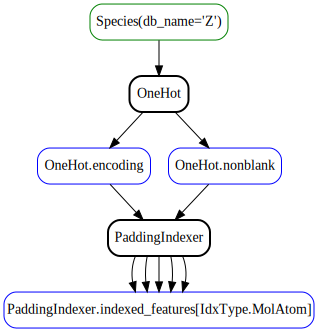

In [26]:
visualize_graph_module(onehot_predictor.graph,compactify=True)

In [27]:
from hippynn.graphs import IdxType
type(IdxType)

enum.EnumMeta

IdxType is an enumeration

In [28]:
dir(IdxType)

['Atoms',
 'MolAtom',
 'MolAtomAtom',
 'Molecules',
 'NotFound',
 'Pair',
 'QuadMol',
 'QuadPack',
 'Scalar',
 '__class__',
 '__doc__',
 '__members__',
 '__module__']

## IdxType tags the "batch information" for the tensor

* On each tensor, the batch might refer to a different quantity
* We can have a batch of atoms, or a batch of molecules
* or a batch of MolAtom, meaning molecules on the first batch axis, followed by atoms on the second batch axis
* Index Types like MolAtom and MolAtomAtom can be conveniently batched over
* Index Types like Atoms and Pair are sparse, and so make for more efficient computation
* To track the relationship between the different batch-types, we need _indexing_ information.
* `hippynn` looks at the index types associated with inputs and outputs and can automatically construct conversions between the types whenever the answer is unambiguous.
* In cases where the automatic construction fails, an advanced user can directly specify the intended result.

Behind the hood, the loss and evaluator also use graphs! 

- This is what allows us to python syntax to build a loss function from algebraic operations.

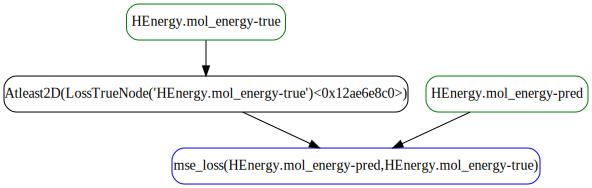

In [29]:
visualize_graph_module(training_modules.loss)

Every model quantity with a db_name can be an input into the loss graph, either in 'true' (database) form, or 'predicted' (model) form:

In [30]:
henergy.mol_energy.true

LossTrueNode('HEnergy.mol_energy-true')<0x12ae6e8c0>

In [31]:
henergy.mol_energy.pred

LossPredNode('HEnergy.mol_energy-pred')<0x107b46560>

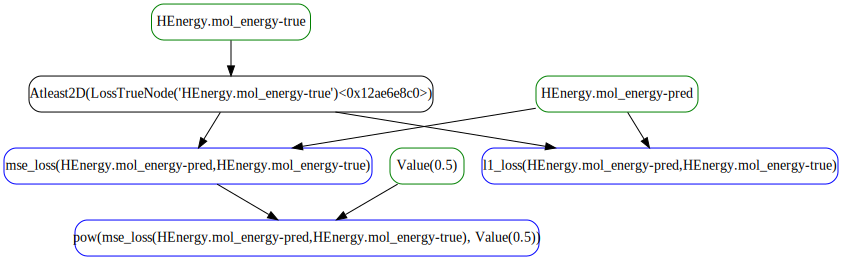

In [32]:
visualize_graph_module(training_modules.evaluator.loss)

# Graph transformations

## ASE Interface

In [33]:
# To run this, train a model using /examples/ani_aluminum_example.py ! 
with hippynn.tools.active_directory('./TEST_ALUMINUM_MODEL/'):
    model=hippynn.experiment.serialization.load_model_from_cwd()

In [34]:
type(model)

hippynn.graphs.graph.GraphModule

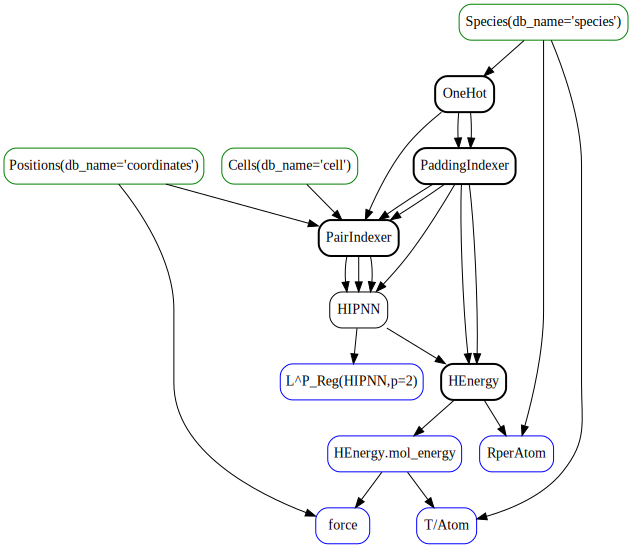

In [35]:
visualize_graph_module(model)

Notice the graph structure is somewhat different here, because, for example, we have per-atom energies to train to, and periopdic boundary conditons.

Let's send this to the Atomic Simulation Environment, a code for performing molecular dynamics in python.

In [36]:
from hippynn.interfaces.ase_interface import calculator_from_model

calc = calculator_from_model(model)

  warnings.warn("No charge node found: ASE interface will not calculate charges or dipole moments.")


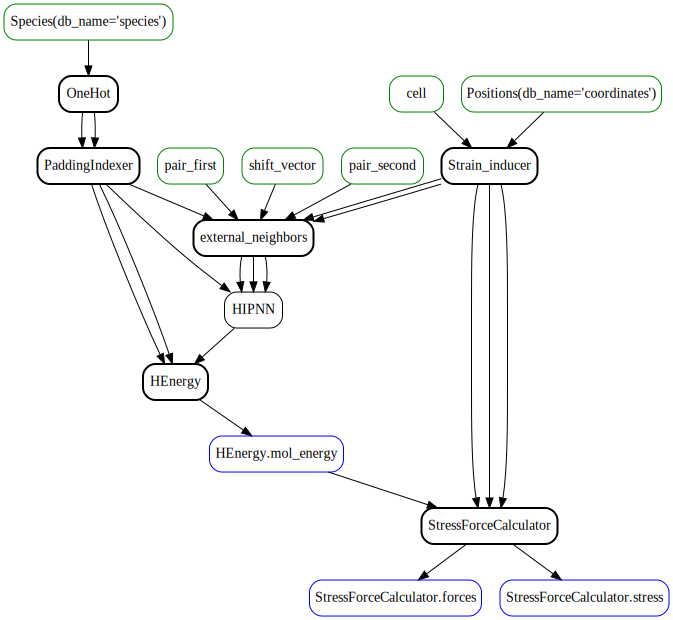

In [37]:
visualize_graph_module(calc.module)

Very similarly, we can send the model to an MLIAPInterface for the LAMMPS molecular dynamics code, which is very useful for highly parallel simulations.

In [38]:
from hippynn.interfaces.lammps_interface import MLIAPInterface

  warnings.warn("This interpreter is not compatible with python-based MLIAP for LAMMPS. "


In [39]:
lammps_interface = MLIAPInterface(model.node_from_name("HEnergy"),element_types=['Al'])

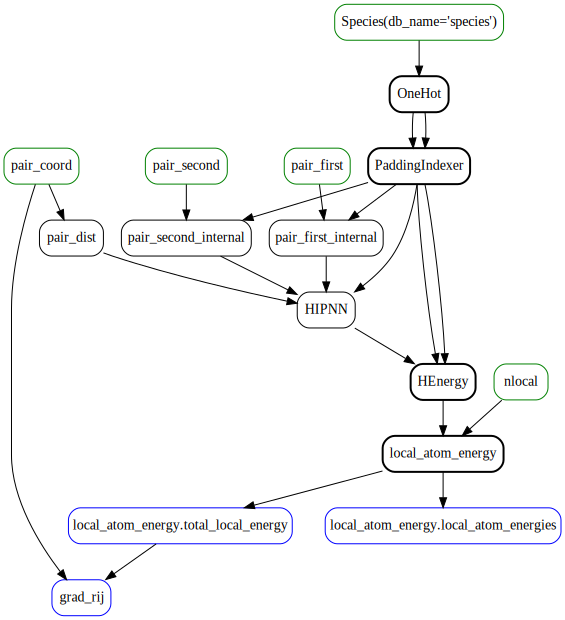

In [40]:
visualize_graph_module(lammps_interface.graph)

# Ensembling

Often it is useful to ensemble multiple models in machine learning. `hippynn` has some tools to automatically ensemble nodes and graphs.

In [41]:
n_ensemble=5
useful_nodes = []

for i in range(n_ensemble):
    this_species = inputs.SpeciesNode(db_name="Z")
    this_positions = inputs.PositionsNode(db_name="R")
    this_network = networks.Hipnn("hipnn_model", (this_species, this_positions), module_kwargs=network_params)
    this_henergy = targets.HEnergyNode("HEnergy", this_network, db_name="T")
    this_force = physics.GradientNode("Force",(this_henergy,this_positions),sign=-1,db_name="F")
    
    useful_nodes.append(this_henergy)
    useful_nodes.append(this_force)

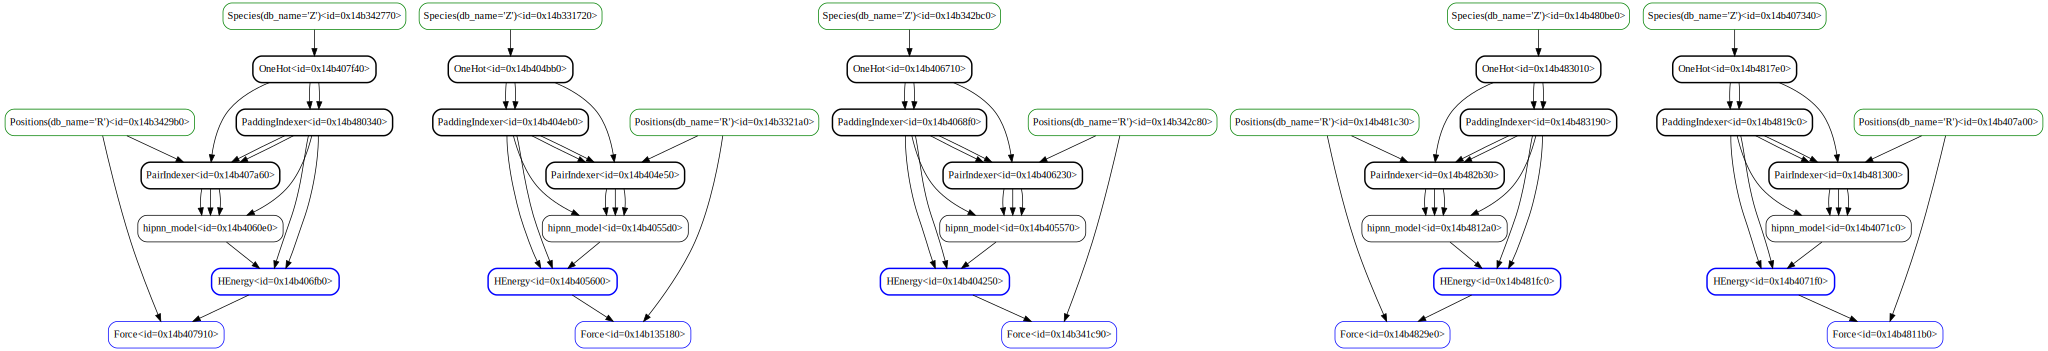

In [42]:
visualize_connected_nodes(useful_nodes)

Note that due to the presence of multiple ndoes with the same name in this visualization, each one is tagged with an its id. 

In [43]:
from hippynn.graphs import make_ensemble

ensemble,ensemble_info = make_ensemble(useful_nodes)

Identified input quantities: {'Z', 'R'}
Identified output quantities: {'T', 'F'}
Inputs needed and respective model counts:
	R : 10
	Z : 10
Outputs generated and respective model counts:
	T : 5
	F : 5
Merged the following nodes from the ensemble members:
	 OneHotEncoder('OneHot')<0x14b483010>
	 PaddingIndexer('PaddingIndexer')<0x14b404eb0>
	 OpenPairIndexer('PairIndexer')<0x14b406230>


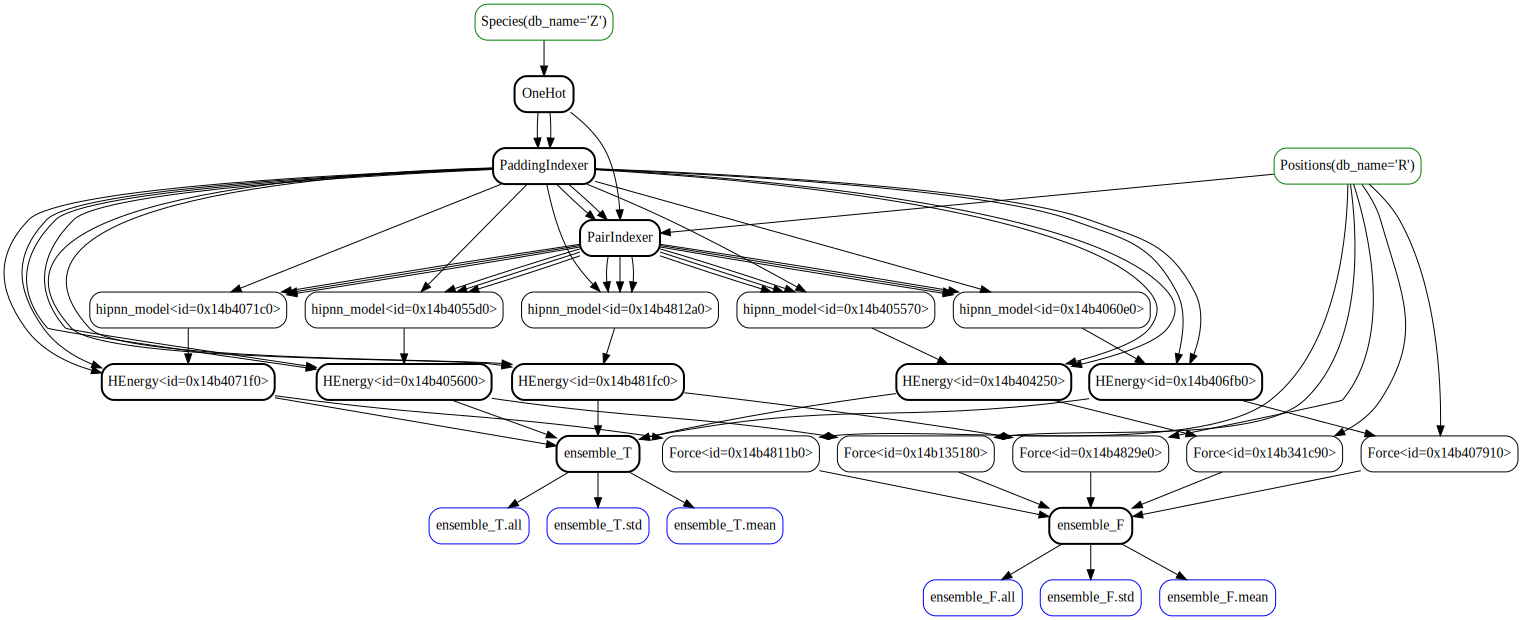

In [44]:
visualize_graph_module(ensemble)

The graph interface allows us to easily glue these models together and share intermediate computations where possible.

Now, the models are merged as far as possible, sharing inputs and early calculations.
 
At the same time, the ensemble quantities for energy ("T") and force ("F") have been constructed as nodes.

In [45]:
ensemble_T = ensemble.node_from_name("ensemble_T")
ensemble_F = ensemble.node_from_name("ensemble_F")

In [46]:
ensemble_predictor = Predictor.from_graph(ensemble)

In [47]:
outputs = ensemble_predictor.apply_to_database(database,batch_size=128)

Predictor:   0%|          | 0/6 [00:00<?, ?batch/s]

Predictor:   0%|          | 0/6 [00:00<?, ?batch/s]

Predictor:   0%|          | 0/45 [00:00<?, ?batch/s]

In [48]:
ensemble_T.mean

IndexNode('ensemble_T.mean')<0x14b4f0520>

In [49]:
outputs['test'][ensemble_T.mean].shape

torch.Size([716, 1])

In [50]:
outputs['test'][ensemble_T.std].shape

torch.Size([716, 1])

The "all" node outputs each individual prediction, stacked:

In [51]:
outputs['test'][ensemble_T.all].shape

torch.Size([716, 5, 1])

In [52]:
outputs['test'][ensemble_F.all].shape

torch.Size([716, 5, 23, 3])

The features above can be intermixed, for example, building an ASE calculator using the ensemble module.

In [53]:
from hippynn.interfaces.ase_interface import HippynnCalculator

In [54]:
ensemble_calculator = HippynnCalculator(ensemble_T.mean)

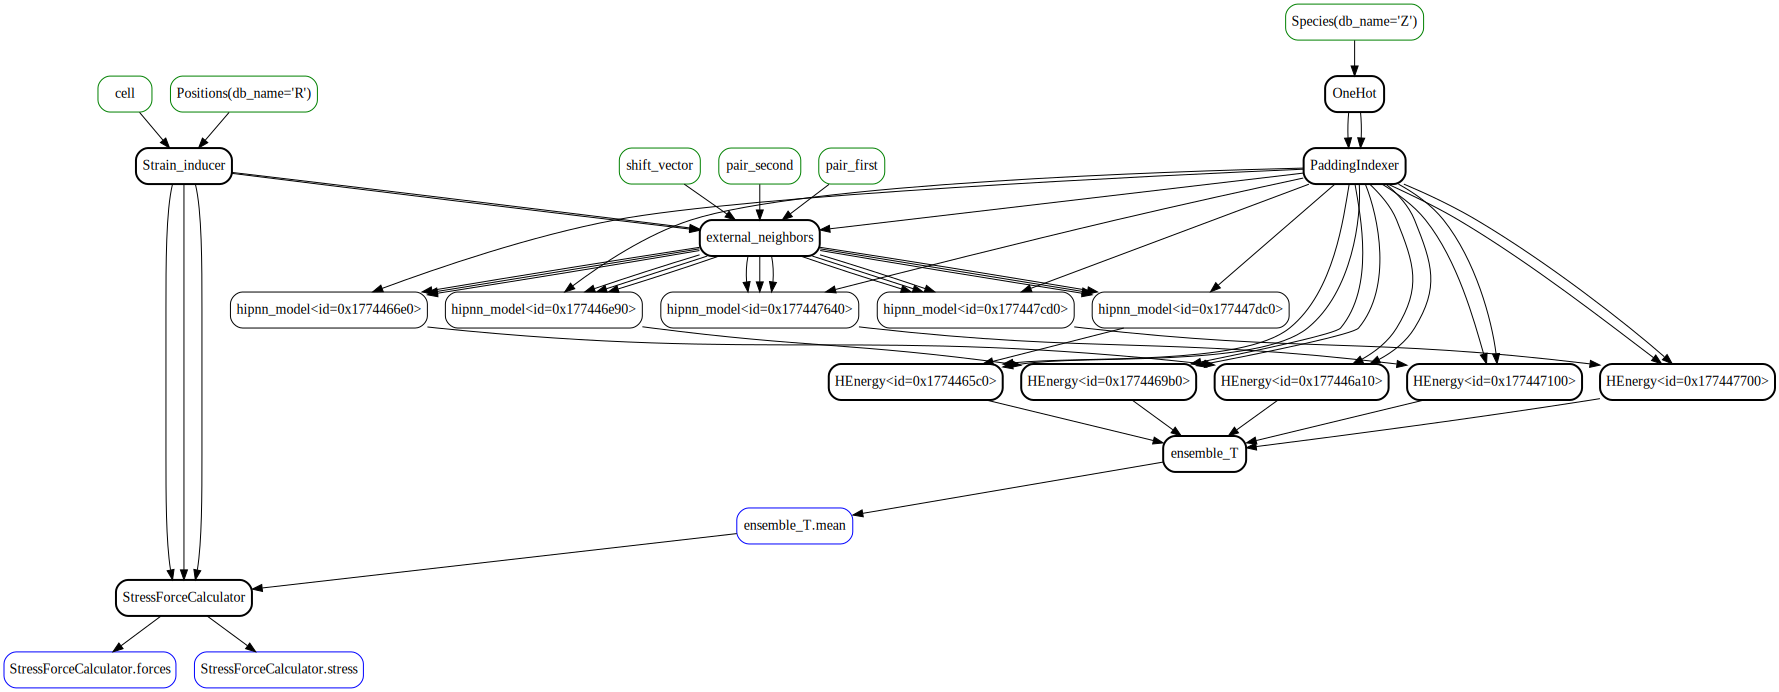

In [55]:
visualize_graph_module(ensemble_calculator.module)